In [1]:
# Importing relevant modules
# 02/04/2025
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Constants
G = 6.67430e-11
AU_to_m = 1.495978707e11
day_to_s = 86400
AUday_to_m_s = AU_to_m / day_to_s 

# Masses
M_sun         = 1.98847e30
M_mercury     = 3.3011e23
M_venus       = 4.8675e24
M_earth_moon  = 5.97237e24 + 7.3477e22  # Earth + Moon
M_mars        = 6.4171e23
M_jupiter     = 1.8982e27

# Creating an array for 6 bodies
masses_6body = np.array([
    M_sun,
    M_mercury,
    M_venus,
    M_earth_moon,
    M_mars,
    M_jupiter
])

# Creating an array for 2 bodies
masses_2body = np.array([
    M_sun,
    M_earth_moon
])

# Data for positions and velocities

positions_au_6body = np.array([
    [ 0.00450250878464055477,  0.00076707642709100705,  0.00026605791776697764],  # Sun
    [ 0.36176271656028195477, -0.09078197215676599295, -0.08571497256275117236],  # Mercury
    [ 0.61275194083507215477, -0.34836536903362219295, -0.19527828667594382236],  # Venus
    [ 0.12051741410138465477, -0.92583847476914859295, -0.40154022645315222236],  # EM bary
    [-0.11018607714879824523, -1.32759945030298299295, -0.60588914048429142236],  # Mars
    [-5.37970676855393644523, -0.83048132656339789295, -0.22482887442656542236],  # Jupiter
])

velocities_au_per_day_6body = np.array([
    [-0.00000035174953607552,  0.00000517762640983341,  0.00000222910217891203],  # Sun
    [ 0.00336749397200575848,  0.02489452055768343341,  0.01294630040970409203],  # Mercury
    [ 0.01095206842352823448,  0.01561768426786768341,  0.00633110570297786403],  # Venus
    [ 0.01681126830978379448,  0.00174830923073434441,  0.00075820289738312913],  # EM bary
    [ 0.01448165305704756448,  0.00024246307683646861, -0.00028152072792433877],  # Mars
    [ 0.00109201259423733748, -0.00651811661280738459, -0.00282078276229867897],  # Jupiter
])

positions_au_2body = np.array([
    positions_au_6body[0],  # Sun
    positions_au_6body[3],  # EM bary
])
velocities_au_per_day_2body = np.array([
    velocities_au_per_day_6body[0],  # Sun
    velocities_au_per_day_6body[3],  # EM bary
])

# Converting to SI Units

positions_m_6body    = positions_au_6body * AU_to_m
velocities_m_s_6body = velocities_au_per_day_6body * AUday_to_m_s

positions_m_2body    = positions_au_2body * AU_to_m
velocities_m_s_2body = velocities_au_per_day_2body * AUday_to_m_s

# Performing the Velocity Verlet Method
def compute_accelerations(pos, masses):
    """
    Inputs:
    pos: Position of bodies
    masses: masses
    Outputs
    accels: array of accelerations
    """
    N = len(masses)
    acc = np.zeros_like(pos)
    for i in range(N):

        r_vec = pos - pos[i]
        dist = np.sqrt(np.sum(r_vec**2, axis=1))
        dist[i] = 1e30
        acc[i] = np.sum(G * masses[:, None] * r_vec / dist[:, None]**3, axis=0)
        
    return acc

def velocity_verlet_integration(initial_pos, initial_vel, masses, dt, num_steps):
    """
   Performs the velocity verlet update
    
    Inputs:
    initial_pos - positons of bodies
    initial_vel - velocities of bodies
    masses - masses of bodies
    dt - timestep
    num_steps - steps

    Outputs:
    all positions = new positions of bodies
    """
    # Initialising
    pos = 1.0 * initial_pos
    vel = 1.0 * initial_vel

    N = len(masses)
    all_positions = np.zeros((num_steps, N, 3))
    
    acc = compute_accelerations(pos, masses)
    for step in range(num_steps):
        # store positions
        all_positions[step] = pos
        
        # 1) update positions
        pos = pos + vel*dt + 0.5*acc*(dt**2)
        
        # 2) compute new accelerations
        new_acc = compute_accelerations(pos, masses)
        
        # 3) update velocities
        vel = vel + 0.5*(acc + new_acc)*dt
        
        acc = new_acc
    
    return all_positions

# time paramaters
dt = 1.0 * day_to_s   # 1 day in seconds
num_steps = 365 * 20  # 20 years


time_array_days = np.arange(num_steps) * (dt / day_to_s)

# Running simulations

all_pos_6body = velocity_verlet_integration(
    positions_m_6body,
    velocities_m_s_6body,
    masses_6body,
    dt,
    num_steps
)

# 2-body system (Sun + EM bary)
all_pos_2body = velocity_verlet_integration(
    positions_m_2body,
    velocities_m_s_2body,
    masses_2body,
    dt,
    num_steps
)

# Computing the difference
earth_moon_6body = all_pos_6body[:, 3, :]

earth_moon_2body = all_pos_2body[:, 1, :]

diff = earth_moon_6body - earth_moon_2body
diff_x = diff[:, 0]
diff_y = diff[:, 1]
diff_z = diff[:, 2]
diff_r = np.sqrt(diff_x**2 + diff_y**2 + diff_z**2)

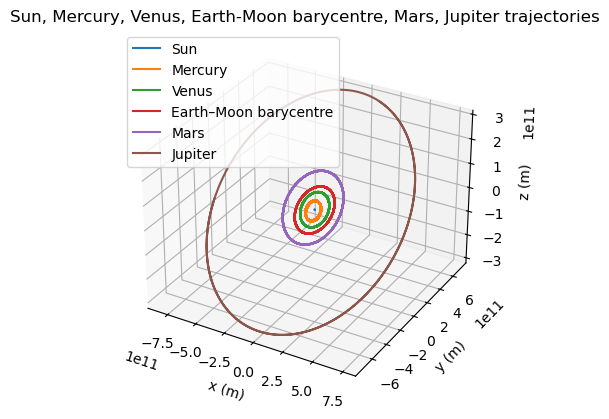

In [3]:
# 6 Body plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

labels_6 = ["Sun", "Mercury", "Venus", "Earth–Moon barycentre", "Mars", "Jupiter"]
for i in range(len(masses_6body)):
    ax.plot(all_pos_6body[:, i, 0], all_pos_6body[:, i, 1], all_pos_6body[:, i, 2],
            label=labels_6[i])

ax.set_title("Sun, Mercury, Venus, Earth-Moon barycentre, Mars, Jupiter trajectories")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.legend()
plt.savefig(fname='solar sun and planets')
plt.show()

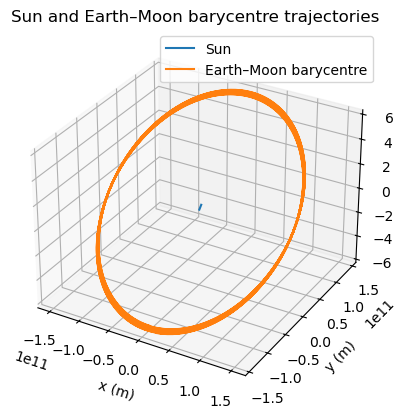

In [4]:
# 2 Body plot
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

labels_2 = ["Sun", "Earth–Moon barycentre"]
for i in range(len(masses_2body)):
    ax2.plot(all_pos_2body[:, i, 0], all_pos_2body[:, i, 1], all_pos_2body[:, i, 2],
             label=labels_2[i])

ax2.set_title("Sun and Earth–Moon barycentre trajectories")
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")
ax2.set_zlabel("z (m)")
ax2.legend()
plt.savefig(fname='solar sun and EM')
plt.show()

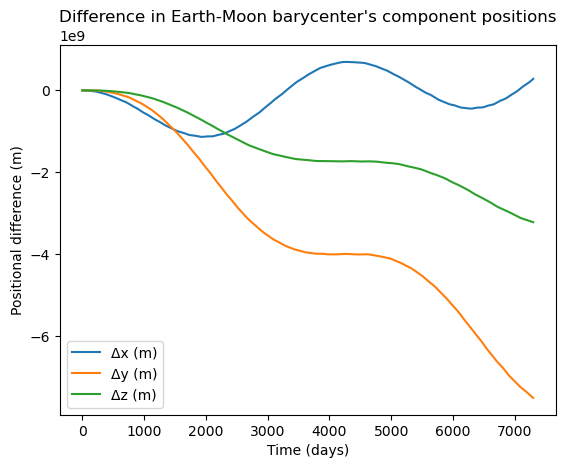

In [5]:
# difference in positions plots
plt.figure()
plt.plot(time_array_days, diff_x, label="Δx (m)")
plt.plot(time_array_days, diff_y, label="Δy (m)")
plt.plot(time_array_days, diff_z, label="Δz (m)")
plt.title("Difference in Earth-Moon barycenter's component positions")
plt.xlabel("Time (days)")
plt.ylabel("Positional difference (m)")
plt.legend()
plt.savefig(fname='solar component diff')
plt.show()

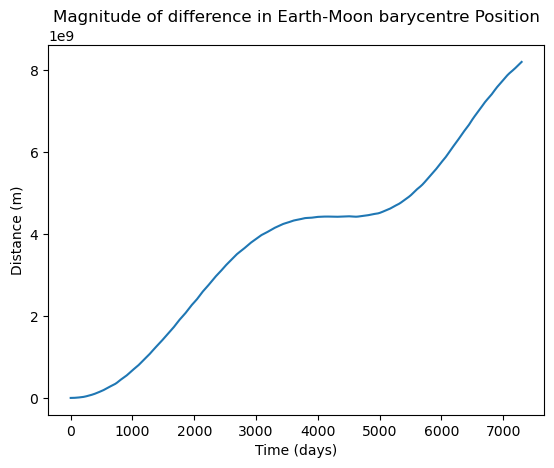

In [6]:
# difference in position magnitude plot
plt.figure()
plt.plot(time_array_days, diff_r)
plt.title("Magnitude of difference in Earth-Moon barycentre Position")
plt.xlabel("Time (days)")
plt.ylabel("Distance (m)")
plt.savefig(fname='solar positional difference')
plt.show()

02/04/2025I had trouble calculating the forces from multiple different bodies, however twiddling with the loops i finally figured it.